In [ ]:
!pip install muspy
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 57.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 5.4 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592305 sha256=fae5f9bd87909d929cccd2b124a13bcde29e8633d7c1da0c743625188b8b43fa
  Stored in directory: /root/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
Successfully built pretty-midi
  Attempting uninstall: music21
    Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0
Re

In [ ]:
import muspy as mp
import music21
import os

import random
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import shutil
import glob
from progressbar import ProgressBar


import collections
import datetime
import fluidsynth
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [ ]:
data_dir = pathlib.Path("major_parts")
filenames = glob.glob(str(data_dir/'*.mid*'))
print('Number of files:', len(filenames))

Number of files: 326


In [ ]:
def create_empty_notes_list(n : int):
  dict_note = []
  for i in range(n):
    dict_note.append(0)
  return dict_note

def normalize_list(l : list):
  total = sum(l)
  if total > 0.0:
    for i in range(len(l)):
      l[i] = l[i]/total

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
def midi_to_notes(midi_file: str, dur_list: list):
  music = mp.from_music21(music21.converter.parse(midi_file))
  unsorted_notes = []
  #assemblage de toutes les pistes de notes
  for track in music.tracks:
    m_notes = track.notes
    if m_notes != []:
      unsorted_notes += m_notes 
  notes = collections.defaultdict(list)

  if unsorted_notes != []:

    # Sort the notes by start time
    sorted_notes = sorted(unsorted_notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    prev_dur = sorted_notes[0].duration

    for note in sorted_notes:
      start = note.start
      duration = note.duration
      end = start + duration
      notes['pitch'].append(note.pitch)
      notes['start'].append(start)
      notes['end'].append(end)
      notes['step'].append(start - prev_start)
      notes['duration'].append(duration)

      if dur_list != []:
        list_to_update_dur = dur_list[prev_dur]
        list_to_update_dur[duration] += 1

      prev_dur = duration
      prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
sample_file = filenames[20]
raw_notes = midi_to_notes(sample_file, [])
pm = pretty_midi.PrettyMIDI(sample_file)

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:

list_notes_dur = []

for i in range(1000):
  prob_duration_notes = create_empty_notes_list(1000)
  list_notes_dur.append(prob_duration_notes)

In [ ]:
import progressbar
all_notes = []
pbar = ProgressBar()

for f in pbar(filenames):
  notes = midi_to_notes(f, list_notes_dur)
  if not notes.empty:
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

100% (326 of 326) |######################| Elapsed Time: 0:31:05 Time:  0:31:05


In [ ]:
key_order = ['pitch']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(1,), dtype=tf.int64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 12,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/vocab_size
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

seq_length = 25
vocab_size = 12
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(TensorSpec(shape=(25, 1), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.int64, name=None)})

In [ ]:

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

train_ds.element_spec

Number of notes parsed: 127350


(TensorSpec(shape=(64, 25, 1), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.int64, name=None)})

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)


In [ ]:
input_shape = (seq_length, 1)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x)
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True)}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 pitch (Dense)               (None, 128)               16512     
                                                                 
Total params: 83,072
Trainable params: 83,072
Non-trainable params: 0
_________________________________________________________________


In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

1989/1989 [==============================] - 63s 21ms/step - loss: 4.8790


{'loss': 4.879034996032715}

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]


Epoch 1/100
1989/1989 [==============================] - 93s 46ms/step - loss: 3.5866
Epoch 2/100
1989/1989 [==============================] - 91s 46ms/step - loss: 3.4580
Epoch 3/100
1989/1989 [==============================] - 91s 46ms/step - loss: 3.4044
Epoch 4/100
1989/1989 [==============================] - 91s 46ms/step - loss: 3.3603
Epoch 5/100
1989/1989 [==============================] - 91s 46ms/step - loss: 3.3324
Epoch 6/100
1989/1989 [==============================] - 92s 46ms/step - loss: 3.3117
Epoch 7/100
1989/1989 [==============================] - 93s 47ms/step - loss: 3.2955
Epoch 8/100
1989/1989 [==============================] - 93s 47ms/step - loss: 3.2820
Epoch 9/100
1989/1989 [==============================] - 91s 46ms/step - loss: 3.2699
Epoch 10/100
1989/1989 [==============================] - 92s 46ms/step - loss: 3.2574
Epoch 11/100
1989/1989 [==============================] - 93s 47ms/step - loss: 3.2516
Epoch 12/100
1989/1989 [============================

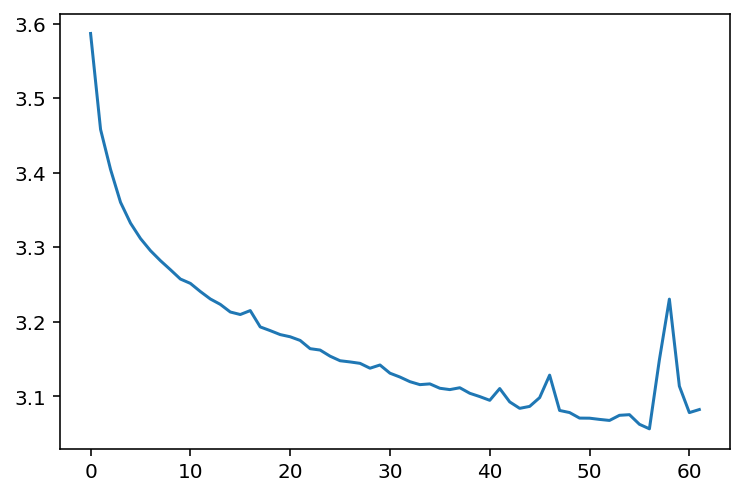

In [ ]:
epochs = 100

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()


In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)


  return int(pitch)


In [ ]:
for i in range(len(list_notes_dur)):
  normalize_list(list_notes_dur[i])

In [ ]:
B =torch.tensor(numpy.transpose(list_notes_dur))
B

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [ ]:
Ld, Vd = torch.linalg.eig(B)
pi1 = Vd[:,0]
pi1 = pi1/torch.sum(pi1)
pi1 = torch.real(pi1)

In [ ]:
num_predictions = 120

In [ ]:
durs = [] #séquence de durées des notes
# initialisation
current_state = torch.multinomial(B.diagonal(),1).item()

durs.append(current_state)

for i in range(num_predictions):
  # transition
  current_state = torch.multinomial(B[:,current_state],1).item()
  durs.append(current_state)

# optionnel
print(durs)

[6, 6, 6, 32, 6, 16, 6, 6, 42, 6, 6, 30, 42, 24, 6, 8, 6, 6, 24, 24, 24, 36, 8, 12, 12, 30, 12, 6, 24, 24, 24, 16, 6, 6, 6, 6, 6, 12, 12, 12, 6, 18, 6, 8, 6, 8, 48, 24, 6, 6, 36, 60, 24, 12, 12, 18, 12, 6, 6, 30, 12, 6, 24, 24, 6, 24, 12, 90, 24, 132, 36, 12, 12, 6, 6, 48, 8, 8, 6, 24, 12, 6, 6, 6, 8, 6, 18, 12, 12, 30, 48, 60, 78, 4, 16, 24, 6, 8, 18, 8, 8, 12, 24, 6, 12, 6, 6, 48, 24, 6, 8, 24, 6, 12, 12, 8, 8, 64, 12, 6, 6]


In [ ]:
temperature = 2.0


sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (sample_notes[:seq_length] /vocab_size)

generated_notes = []
prev_start = 0
prev_dur = 0
for i in range(num_predictions):
  pitch = predict_next_note(input_notes, model, temperature)
  pitch=pitch%12+72
  duration = 0.05 * durs[i]
  step = duration
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims([pitch],0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=('pitch','step','duration', 'start', 'end'))

print(generated_notes.head(10))

1/1 [==============================] - 0s 41ms/step
   pitch  step  duration  start  end
0     82   0.3       0.3    0.3  0.6
1     72   0.3       0.3    0.6  0.9
2     80   0.3       0.3    0.9  1.2
3     72   1.6       1.6    2.5  4.1
4     79   0.3       0.3    2.8  3.1
5     81   0.8       0.8    3.6  4.4
6     81   0.3       0.3    3.9  4.2
7     81   0.3       0.3    4.2  4.5
8     75   2.1       2.1    6.3  8.4
9     81   0.3       0.3    6.6  6.9


In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)


Number of instruments: 2
Instrument name: Bright Acoustic Piano


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)